# ASAP 2.0 analyses

Find optimal hyperparameters on the ASAP 2.0 dataset using DeBERTa-v3-Large

This is the reduced dataset (contains none of the PERSUADE essays)

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from scipy import stats
from IPython.display import display
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    DefaultDataCollator
)
import wandb # Weights and Biase

# Replace the variables below with your own: name, project name, and project directory
%env WANDB_PROJECT = asap
%env WANDB_DIR = bin
%env WANDB_NOTEBOOK_NAME = asap_llm_modeling_baseline.ipynb

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


env: WANDB_PROJECT=asap
env: WANDB_DIR=bin
env: WANDB_NOTEBOOK_NAME=asap_llm_modeling_baseline.ipynb


## Configure Logging

In [2]:
from transformers import logging
logging.set_verbosity_error()
%env WANDB_SILENT = true

env: WANDB_SILENT=true


## Load and Prepare ASAP Corpus

In [5]:
asap_df = pd.read_csv("data/ASAP2_new_IN_data_only_w_splits.csv")

asap_df.sample(2)

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task,stratified_split
3367,AAAOPP13416000101260,3,"I think that creating ""Driverless Cars"" should...",test,public,"In the article “Driverless Cars are Coming,” t...",Driverless cars,Economically disadvantaged,Not identified as having disability,No,Two or more races/Other,M,10,268.0,MI,Text dependent,train
2655,AAAOPP13416000038254,3,"To most people, driving can be a chore. Drivin...",train,0,"In the article “Driverless Cars are Coming,” t...",Driverless cars,Economically disadvantaged,Not identified as having disability,No,Black/African American,F,10,309.0,MI,Text dependent,train


In [6]:
asap_df_clean = (
    asap_df[['full_text', 'score', 'stratified_split']]
    .rename(
        columns={
            'full_text': 'text',
            'score': 'label',
        }
    )
    .assign(label=lambda df: df.label.astype('float'))
    .reset_index(drop=True)
)

asap_df_clean.sample(2)

,text,label,stratified_split
6704,I say that the auther did do really good suppo...,2.0,test
3587,Driverless cars do seem like something nice to...,3.0,train


## Simple word count

In [7]:
asap_df_clean.text.str.split().str.len().describe()

count    11826.000000
mean       352.905209
std        139.200520
min        150.000000
25%        246.000000
50%        330.000000
75%        434.000000
max       1231.000000
Name: text, dtype: float64

### Get training and test sets

These are already defined in the datasets. Just need to divide and name them

This is with a validation set used for hyperparameters

Training and test sets would be different and found underset.



In [9]:
# What's in there?

sets = asap_df_clean['stratified_split'].unique()
print(sets)

['train' 'test' 'dev']


In [15]:
asap_dd = DatasetDict({
    "train": Dataset.from_pandas(asap_df_clean[asap_df_clean["stratified_split"] == "train"].reset_index(drop=True)),
    # Use a subsample to validate the notebook:
    # "train": Dataset.from_pandas(
    #     asap_df_clean[asap_df_clean["pubpriv"] == "0"]
    #     .reset_index(drop=True)
    #     .sample(200)
    # ),
    "dev": Dataset.from_pandas(asap_df_clean[asap_df_clean["stratified_split"] == "dev"].reset_index(drop=True)),
    "test": Dataset.from_pandas(asap_df_clean[asap_df_clean["stratified_split"] == "test"].reset_index(drop=True)),
})
asap_dd["dev"]

Dataset({
    features: ['text', 'label', 'stratified_split'],
    num_rows: 2956
})

### Pre-process inputs (tokenization)


In [16]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large', use_fast=False)

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation=True, max_length=512)

In [18]:
asap_dd_tokenized = asap_dd.map(tokenize_inputs, batched=True, remove_columns=['text'])

Map: 100%|██████████| 2957/2957 [00:04<00:00, 616.73 examples/s]


In [19]:
asap_dd_tokenized['train']

Dataset({
    features: ['label', 'stratified_split', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5913
})

### Data Collator
A data collator feeds the data to the language model. [More information](https://huggingface.co/course/chapter3/2?fw=pt).




In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
def model_init(config):
    return AutoModelForSequenceClassification.from_pretrained(
        'microsoft/deberta-v3-large',
        num_labels=1, # Regression
        pooler_dropout=config.pooler_dropout
    )

### Define Metrics

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {"mse": mean_squared_error(logits, labels)}

### Hyperparameter Optimization

Config is based on Appendix A.4:

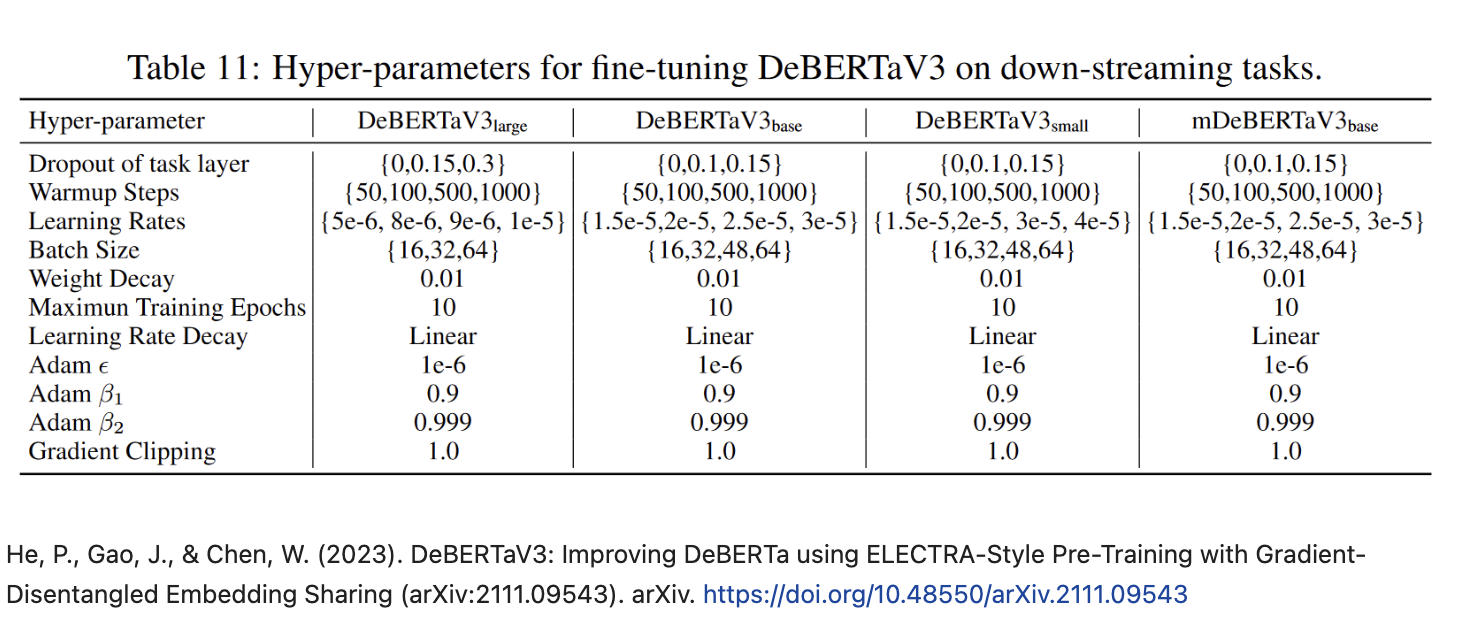

In [23]:
sweep_config = {
    'name': 'deberta-v3-large',
    'method': 'bayes', #bayes
    'run_cap': 42, # bayesian optimizer will run until stopped if this is not set
    'metric': {
        'name': f'eval/mse', # mean squared error
        'goal': 'minimize'}, # we want to "minimize" the mean squared error.
    'parameters': {
        'batch_size': {'value': 2}, # batch size of 2 is required due to memory limitations and long sequence lengths
        'gradient_accumulation_steps': {'values': [16, 32, 64]},
        'learning_rate': {'values': [5e-6, 8e-6, 9e-6, 1e-5]},
        'num_train_epochs': {'values': [2, 3, 4, 5]}, # Up to 10 epochs are suggested, so we may need to extend this range if models are still improving at 4-5 epochs.
        'pooler_dropout': {'values': [0, 0.15, 0.30]}, #Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the input units to 0 during training
        'weight_decay': {'value': 0.01}, #hyperparameter that controls the L2 regularization applied to the model's weights during training. L2 regularization is a common technique used to prevent overfitting by adding a penalty term to the loss function, proportional to the square of the model's weights
        'adam_beta1': {'value': 0.900}, #hyperparameters of the Adam optimization algorithm, which is used to update the model's weights during training
        'adam_beta2': {'value': 0.999},
        'adam_epsilon': {'value': 1e-6},
        'warmup_steps': {'values': [50, 100, 500, 1000]}, #hyperparameter that controls the number of initial training steps during which the learning rate is gradually increased from a small value to the full learning rate
    },
}

In [24]:
def train():
    with wandb.init():
        # set sweep configuration
        config = wandb.config

        # Customize the trainer
        training_args = TrainingArguments(
            output_dir = 'bin', 
            optim = 'adamw_torch', # Specify your optimizer
            logging_dir = 'logs', 
            load_best_model_at_end = False, # Do not load the best model at the end
            metric_for_best_model = 'mse', # We will be using mean squared error to evaluate model performance
            evaluation_strategy='epoch', # Evaluate model performance at the end of each epoch
            save_strategy='no', # checkpoints are saved after each epoch 
            greater_is_better = False, # mse likes lower
            log_level = 'error', # only error-level messages will be logged
            disable_tqdm = False, # show progress bar
            report_to='wandb',
            # The hyper parameters we are tuning (number of epochs, learning rate, and batch size)
            # are called in from the configuration dictionary
            num_train_epochs=config.num_train_epochs,
            warmup_steps=config.warmup_steps,
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=16,
        )

        model = model_init(config)

        # Initialize the trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=asap_dd_tokenized['train'],
            eval_dataset=asap_dd_tokenized['dev'],
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
        )


        # Start training loop
        trainer.train()

In [ ]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, train)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find asap_llm_modeling_baseline.ipynb.


Create sweep with ID: h50sgkms
Sweep URL: https://wandb.ai/scrosseye-vanderbilt-university/asap/sweeps/h50sgkms


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.391300,0.422924,0.422924
2,0.308700,0.319580,0.319580
3,0.238700,0.319267,0.319267


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.368900,0.356938,0.356938
2,0.323200,0.330731,0.330731
3,0.266200,0.348230,0.348230


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.397300,0.416625,0.416625
2,0.324100,0.334319,0.334319
3,0.256800,0.329746,0.329746


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.406500,0.386739,0.386739
2,0.326400,0.326989,0.326989
3,0.283900,0.328823,0.328823
4,0.182500,0.344158,0.344158


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.403800,0.411318,0.411318
2,0.337300,0.332667,0.332667
3,0.265600,0.322215,0.322215
4,0.186900,0.327245,0.327245


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.416200,0.374970,0.374970
2,0.330700,0.360954,0.360954
3,0.264100,0.332048,0.332048


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.380400,0.369646,0.369646
2,0.306200,0.318372,0.318372
3,0.243100,0.317358,0.317358


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.411200,0.352116,0.352116
2,0.338800,0.348006,0.348006
3,0.272700,0.325355,0.325355
4,0.188300,0.346414,0.346414


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.392100,0.371050,0.371050
2,0.317700,0.339962,0.339962
3,0.271800,0.319798,0.319798


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.380400,0.359368,0.359368
2,0.307800,0.321302,0.321302
3,0.245400,0.326661,0.326661


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.418400,0.397235,0.397235
2,0.329200,0.331867,0.331867
3,0.281200,0.328873,0.328873


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.397700,0.483825,0.483825
2,0.336200,0.345435,0.345435
3,0.279800,0.322257,0.322257


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.394300,0.362626,0.362626
2,0.318000,0.331131,0.331131
3,0.257600,0.322089,0.322089


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.412200,0.391074,0.391074
2,0.332700,0.337769,0.337769
3,0.248300,0.320978,0.320978


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.399700,0.394003,0.394003
2,0.324100,0.329347,0.329347
3,0.275000,0.322474,0.322474


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.411400,0.372739,0.372739
2,0.324300,0.324294,0.324294
3,0.263200,0.321779,0.321779


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.415600,0.376583,0.376583
2,0.333500,0.341505,0.341505
3,0.272200,0.321658,0.321658
4,0.187900,0.333779,0.333779


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.389800,0.389840,0.389840
2,0.316300,0.331383,0.331383
3,0.256800,0.324231,0.324231


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.393800,0.403490,0.403490
2,0.325400,0.329259,0.329259
3,0.255400,0.316838,0.316838


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.399600,0.365796,0.365796
2,0.331800,0.321934,0.321934
3,0.272400,0.323202,0.323202


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.401200,0.375533,0.375533
2,0.315700,0.366048,0.366048
3,0.248700,0.326005,0.326005


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.386200,0.374023,0.374023
2,0.321800,0.346640,0.346640
3,0.235500,0.330133,0.330133


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.400900,0.403887,0.403887
2,0.323900,0.339080,0.339080
3,0.260200,0.328073,0.328073


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.400300,0.366654,0.366654
2,0.328400,0.339379,0.339379
3,0.264700,0.321059,0.321059


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.393600,0.387975,0.387975
2,0.334900,0.360786,0.360786
3,0.261300,0.321962,0.321962


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.392200,0.434888,0.434888
2,0.324500,0.359155,0.359155
3,0.272800,0.326583,0.326583


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.398600,0.376850,0.376850
2,0.318000,0.344973,0.344973
3,0.262400,0.319486,0.319486


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse
1,0.395200,0.369308,0.369308
2,0.328000,0.327031,0.327031
